# Reading in data

## Version two: Constructs two dataframes, with different approaches to label columns


In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta 
import seaborn as sns
import re 
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder
import sklearn

import matplotlib.pyplot as plt

In [2]:
# Path to data
path = 'alldata/'

# String to specify ind date
end_date = '2020-04-23 23:51:00'


In [3]:
def make_dataframes(path):
    file_names = [pos_csv for pos_csv in os.listdir(path) if pos_csv.endswith('.csv')]
    dataframes = {}
    dfs = []
    for i, file in enumerate(file_names):
        df_name = ("df_" + file)[:-4]
        dfs.append(pd.read_csv(path + file))
        dataframes[df_name] = dfs[i]
    return dataframes, file_names

data_dict, files = make_dataframes(path)

In [4]:
# We created a dictionary of dataframes:
data_dict.keys()
# These are the dataframes:

dict_keys(['df_survey_raw', 'df_current_log', 'df_weather_log', 'df_weekpop_df', 'df_binned_weather_history', 'df_binned_current_log', 'df_image_label', 'df_ProspectParkSurvey', 'df_curpop_df', 'df_image_label_isa', 'df_survey_clean_ap1', 'df_Survey_clean'])

## Twitter tagged data

In [5]:
# We join them on the time_bin column:
data_dict['df_image_label_isa'] = data_dict['df_image_label_isa'].rename(columns={"timetaken": "time_bin"})

In [6]:
def fix_time_format(df):
    """ 
    Turn format to same format for df with 'time_bin' datetime object column.
    """
    print("before:", df['time_bin'].dtype)
    df['time_bin']= pd.to_datetime(df['time_bin']) 
    print("after:", df['time_bin'].dtype)
#    df['time_bin'] = df['time_bin'].dt.strftime('%Y-%m-%d %H:%M')


In [7]:
# Read in pkl tweets into dataframe:
path_to_pkl = "alldata/geotweets_labeled_binned.pkl"

def read_pkl(path_to_pkl):
    tweets = pd.read_pickle(path_to_pkl)
    
    # Create tweets_safe (time bin column, safe score column)
    print(tweets.dtypes)
   # tweets['time_bin'] = tweets['time_bin'].astype(str)
    tweets_safe = tweets[pd.notnull(tweets['safe'])]
#     tweets_safe = tweets.groupby('time_bin').agg(avg_safe=('safe', 'mean'), num_tweets =('time_bin', 'count'))
#     #tweets_safe = tweets.groupby('time_bin').agg({'safe':['mean'], 'safe':['sum']})
#     print(len(tweets_safe))
#     tweets_safe = tweets_safe.drop(columns=['num_tweets'])
#     tweets_safe.columns
    tweets_safe = tweets_safe.reset_index()
    
    # tweets need to be changed to stardard labels: safe = 0, unsafe = 1
    tweets_safe["safe"] = tweets_safe["safe"].replace([0, 1], [1,0])
    
#    fix_time_format(tweets_safe)

    
    # create tweets_count (time bin column, number of tweets)
    tweets_count = tweets.groupby('time_bin').agg(avg_safe=('safe', 'mean'), num_tweets =('time_bin', 'count'))
    tweets_count = tweets_count.drop(columns=['avg_safe'])
    tweets_count = tweets_count.reset_index()
    
    
    return tweets_safe, tweets_count

tweets_safe, tweets_count = read_pkl(path_to_pkl)

date           datetime64[ns, US/Eastern]
text                               object
username                           object
day_of_week                        object
hour                                int64
safe                              float64
time_bin                   datetime64[ns]
dtype: object


# Make one big dataframe

In [8]:
considered_dfs = ['df_curpop_df',
                  'df_binned_current_log',
                  'df_image_label_isa',
                  'df_Survey_clean',
                  'df_binned_weather_history']

def convert_and_examine_time(considered_dfs):
    for df in considered_dfs:
        print("df name:", df)
        fix_time_format(data_dict[df])
        print('begins:', data_dict[df]['time_bin'].min(), 
              "\nends:", data_dict[df]['time_bin'].max(), 
              "\nnon-na vals:", data_dict[df]['time_bin'].count(), "\n\n" )
    print("df name:", "tweets_safe")
    print('begins:', tweets_safe['time_bin'].min(), 
          "\nends:", tweets_safe['time_bin'].max(), 
          "\nnon-na vals:", tweets_safe['time_bin'].count())

convert_and_examine_time(considered_dfs)

df name: df_curpop_df
before: object
after: datetime64[ns]
begins: 2020-04-02 15:05:00 
ends: 2020-04-09 17:05:00 
non-na vals: 663 


df name: df_binned_current_log
before: object
after: datetime64[ns]
begins: 2020-04-04 08:35:00 
ends: 2020-04-10 15:50:00 
non-na vals: 483 


df name: df_image_label_isa
before: object
after: datetime64[ns]
begins: 2020-04-02 16:05:00 
ends: 2020-04-07 18:20:00 
non-na vals: 54 


df name: df_Survey_clean
before: object
after: datetime64[ns]
begins: 2010-04-09 11:50:00 
ends: 2020-04-22 16:50:00 
non-na vals: 106 


df name: df_binned_weather_history
before: object
after: datetime64[ns]
begins: 2019-12-31 23:50:00 
ends: 2020-04-11 22:50:00 
non-na vals: 9789 


df name: tweets_safe
begins: 2020-03-23 14:05:00 
ends: 2020-04-13 07:05:00 
non-na vals: 32


In [9]:
# Join dataframes on time_bin column:

df_full = pd.merge(data_dict['df_curpop_df'], data_dict['df_binned_weather_history'], on='time_bin', how='outer')

# Standardize models

# labels from df_Survey_clean
var_mt = pd.merge(data_dict['df_Survey_clean'][['time_bin','main_track']], df_full, on='time_bin', how='left')
var_mt = var_mt.rename(columns={'main_track':'label'})
var_mt['source'] = "mt"

# labels from df_image_label_isa (label column) (column is already named correctly)
var_label = pd.merge(data_dict['df_image_label_isa'][['time_bin','label']], df_full, on='time_bin', how='left')
var_label['source'] = "h"

# labels from df_image_label_isa (Isa column)
var_isa = pd.merge(data_dict['df_image_label_isa'][['time_bin','Isa']], df_full, on='time_bin', how='left')
var_isa = var_isa.rename(columns={'Isa':'label'})
var_isa['source'] = "i"

# labels from tweets_safe (safe label)
var_tw = pd.merge(tweets_safe[['time_bin','safe']], df_full, on='time_bin', how='left')
var_tw = var_tw.rename(columns={'safe':'label'})
var_tw['source'] = "tw"

# Join frames together
frames = [var_mt, var_label, var_isa, var_tw]
df_full = pd.concat(frames, ignore_index=True)

# Create day/hour variables (since we suspect these may be relevant to how safe/unsafe PP is at in a given time_bin)
df_full['day_name'] = df_full['time_bin'].dt.day_name()
df_full['hour'] = df_full['time_bin'].dt.hour


In [10]:
df_full

,time_bin,label,Unnamed: 0,current_popularity,datetime,time,temperature,dewpoint,humidity,precipitation,windspeed,winddirection,pressure,source,day_name,hour
0,2020-04-08 18:20:00,1.0,579.0,43.0,4/8/2020 18:24,NaN,62.060,9.40,62.0,0.0,20.35,345.0,1001.250,mt,Wednesday,18
1,2020-04-08 18:20:00,1.0,580.0,40.0,4/8/2020 18:34,NaN,62.060,9.40,62.0,0.0,20.35,345.0,1001.250,mt,Wednesday,18
2,2020-04-04 15:50:00,2.0,201.0,63.0,4/4/2020 15:53,2020-04-04 16:00:00,51.980,5.60,69.0,0.0,14.80,40.0,1016.800,mt,Saturday,15
3,2020-04-04 15:50:00,2.0,202.0,69.0,4/4/2020 16:03,2020-04-04 16:00:00,51.980,5.60,69.0,0.0,14.80,40.0,1016.800,mt,Saturday,15
4,2020-04-07 18:20:00,1.0,488.0,42.0,4/7/2020 18:21,NaN,61.520,1.30,36.0,0.0,22.15,195.0,1011.500,mt,Tuesday,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,2020-04-08 21:20:00,1.0,NaN,NaN,NaN,NaN,63.500,8.85,57.0,0.0,22.30,350.0,1001.550,tw,Wednesday,21
321,2020-04-09 08:50:00,1.0,613.0,21.0,4/9/2020 8:55,2020-04-09 09:00:00,46.040,7.20,96.0,0.0,5.40,140.0,1001.200,tw,Thursday,8
322,2020-04-11 18:05:00,1.0,NaN,NaN,NaN,NaN,52.475,-6.30,28.5,0.0,31.15,267.5,1012.525,tw,Saturday,18
323,2020-04-12 09:50:00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tw,Sunday,9


# Post-merge EDA

In [11]:
# Pandas profiling Report
# profile = ProfileReport(df_full, title='report', html={'style':{'full_width':True}})
# profile.to_file(output_file="report.html")

In [12]:
# We can see we are missing a lot of data for some variables:
df_full.count()

time_bin              325
label                 324
Unnamed: 0            221
current_popularity    221
datetime              221
time                   75
temperature           243
dewpoint              243
humidity              243
precipitation         243
windspeed             243
winddirection         243
pressure              243
source                325
day_name              325
hour                  325
dtype: int64

In [13]:
df_full.shape

(325, 16)

Project criteria: **We will only include data from March 23rd, 2020 onward**:

In [14]:
df = df_full[df_full['time_bin'] >= '3/23/2020 00:00']
print("before filtering:", df_full.shape, "\nafter filtering:", df.shape)

before filtering: (325, 16) 
after filtering: (321, 16)


# EDA of original data

We have a few variables we can use to build a labelled column - we have a lot of missing values, so we can cobble a target variable using different columns:

- main_track: from survey data on how busy the main track of the park is (df_Survey_clean)
- label, Isa: from photos (df_image_label_isa)
- tweets_safe: from twitter scraping data


In [15]:
len1 = len(df_full)
print("We have", len(df_full), "observations for", df_full['time_bin'].nunique(), "time bins.",
     "\nWe drop rows before March 22nds, and have", len(df), "observations left.")


We have 325 observations for 164 time bins. 
We drop rows before March 22nds, and have 321 observations left.


Drop rows that we don't have zeros or ones for:

In [16]:
print("Before dropping we have", df.shape, "observations left.")
print(df['label'].value_counts(dropna=False))
df = df[df['label'].notna()]
print(df['label'].value_counts(dropna=False))
print(df['label'].dtypes)
print(df.columns)
df = df[['time_bin', 'label', 'current_popularity',
       'temperature', 'humidity', 'precipitation',
       'windspeed', 'day_name', 'source', 'hour']]
df = df[df['label']!=2]
print(df['label'].value_counts(dropna=False))
print(df.columns)
print("After dropping we have", df.shape, "observations left.")

Before dropping we have (321, 16) observations left.
0.0    145
1.0    106
2.0     69
NaN      1
Name: label, dtype: int64
0.0    145
1.0    106
2.0     69
Name: label, dtype: int64
float64
Index(['time_bin', 'label', 'Unnamed: 0', 'current_popularity', 'datetime',
       'time', 'temperature', 'dewpoint', 'humidity', 'precipitation',
       'windspeed', 'winddirection', 'pressure', 'source', 'day_name', 'hour'],
      dtype='object')
0.0    145
1.0    106
Name: label, dtype: int64
Index(['time_bin', 'label', 'current_popularity', 'temperature', 'humidity',
       'precipitation', 'windspeed', 'day_name', 'source', 'hour'],
      dtype='object')
After dropping we have (251, 10) observations left.


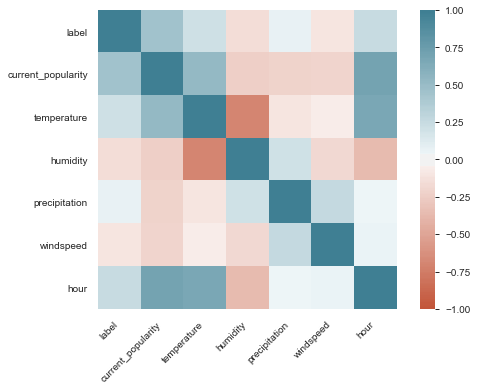

In [17]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

We can probably do something a bit more meaningful by exploding day_name:

In [18]:
# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(df[['day_name']]).toarray())

# merge with main df bridge_df on key values
df_m = df.join(enc_df)
df_m.head(1)


,time_bin,label,current_popularity,temperature,humidity,precipitation,windspeed,day_name,source,hour,0,1,2,3,4,5,6
0,2020-04-08 18:20:00,1.0,43.0,62.06,62.0,0.0,20.35,Wednesday,mt,18,0.0,0.0,0.0,0.0,0.0,0.0,1.0


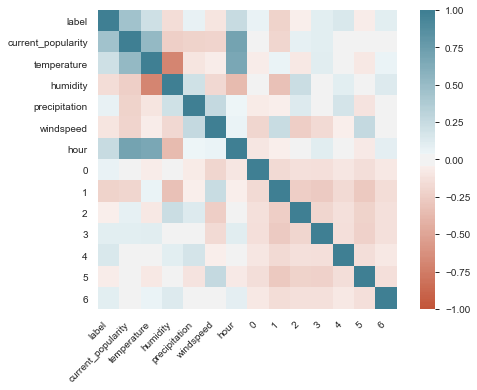

In [19]:
corr = df_m.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Look at some counts w/crosstab:

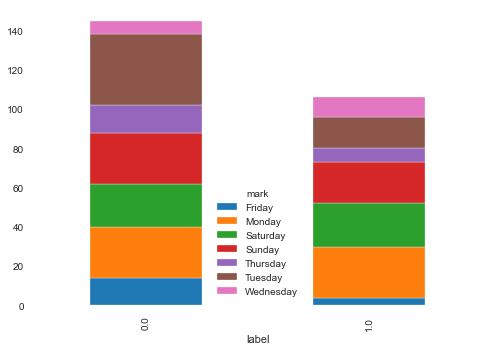

In [20]:
# Table of survival vs passenger class
t1 = pd.crosstab(index=df_m["label"], columns=df_m["day_name"])
t1.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

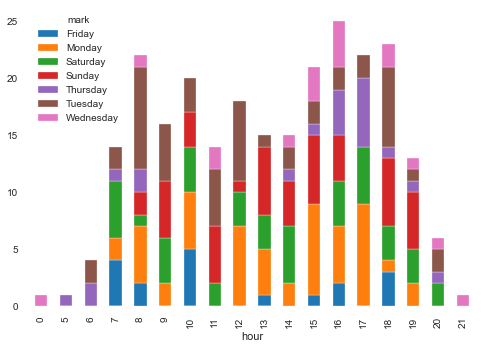

In [21]:
t2 = pd.crosstab(index=df_m["hour"], columns=df_m["day_name"])

t2.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

In [22]:
t3 = pd.crosstab(index=df_m["label"], columns=df_m["hour"])
t3

hour,0,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
label,,,,,,,,,,,,,,,,,,
0.0,1,1,4,11,17,12,16,9,12,7,4,9,8,10,8,11,5,0
1.0,0,0,0,3,5,4,4,5,6,8,11,12,17,12,15,2,1,1


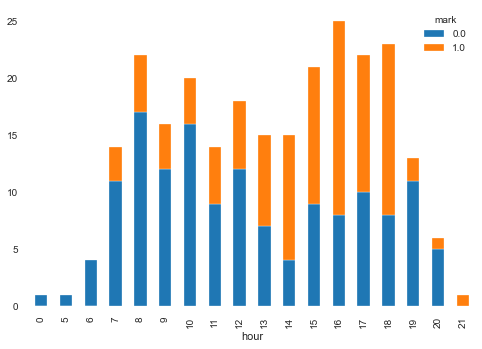

In [23]:
t4 = pd.crosstab(index=df_m["hour"], columns=df_m["label"])

t4.plot.bar(stacked=True)
plt.legend(title='mark')

plt.show()

# MVP Model

In [24]:
from sklearn import metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [25]:
df_m = df_m[['label', 'current_popularity', 'temperature', 'precipitation', 'windspeed', 'hour', 0,1,2,3,4,5,6]]
df_m.head(1)

,label,current_popularity,temperature,precipitation,windspeed,hour,0,1,2,3,4,5,6
0,1.0,43.0,62.06,0.0,20.35,18,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
print(df_m.shape)
df_m = df_m.dropna()
print(df_m.shape)

(251, 13)
(128, 13)


In [27]:
x = df_m.drop('label',axis = 1)
y = df_m['label']

# Split data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=4)

# Create model
clf = LogisticRegression(random_state=0).fit(x_train, y_train)


y_pred = clf.predict(x_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
accuracy_percentage = 100 * accuracy

print("accuracy:", accuracy_percentage)
print("\nClassificationReport")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix")

# cm = confusion_matrix(y.tolist(), y_pred.tolist())

# fig, ax = plt.subplots(figsize=(8, 8))
# ax.imshow(cm)
# ax.grid(False)
# ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
# ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
# ax.set_ylim(1.5, -0.5)
# for i in range(2):
#     for j in range(2):
#         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
# plt.show()

# print(confusion_matrix)


accuracy: 81.25

ClassificationReport
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88        21
         1.0       1.00      0.45      0.62        11

    accuracy                           0.81        32
   macro avg       0.89      0.73      0.75        32
weighted avg       0.85      0.81      0.79        32


Confusion Matrix


/Users/isaurr/src/social_distancing/cleaning/env_sd/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


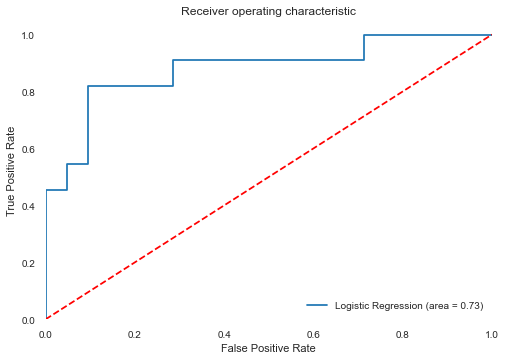

In [28]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, clf.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

ROC could be better, but not too bad for a first pass.

# Imputing data

Trying out a few different things to see how these strategies change data.

In [29]:
df_full.shape

(325, 16)

In [30]:
# We want to create time_bins for all valid day/times (not only those with labels)
# These time bins will be populated with imputed data

# end_date is specified at the head of the notebook

all_tb = (pd.DataFrame(columns=['NULL'],
                  index=pd.date_range('2020-03-23 00:05:00', end_date,
                                      freq='15T'))
       .between_time('07:00','21:00')
       .index.strftime('%Y-%m-%dT%H:%M:%S')
       .tolist()
)


# This is silly: TODO: fix this part, is uneccessary!
all_tb = [all_tb[i][:10] + " " + all_tb[i][11:] for i in range(len(all_tb))]

# All time bins:
all_tb[0:5]

# # Create dataframe

df_tb = pd.DataFrame(all_tb)
df_tb = df_tb.rename(columns={0:'time_bin'})
fix_time_format(df_tb)
df_tb

# # Full join on time_bin labels:
df_tb = pd.merge(df_full, df_tb, on='time_bin', how='outer')
print(df_tb.shape)
df_tb.tail()

before: object
after: datetime64[ns]
(1962, 16)


,time_bin,label,Unnamed: 0,current_popularity,datetime,time,temperature,dewpoint,humidity,precipitation,windspeed,winddirection,pressure,source,day_name,hour
1957,2020-04-23 19:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958,2020-04-23 20:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959,2020-04-23 20:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960,2020-04-23 20:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961,2020-04-23 20:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Using naive strategies to impute data:

In [31]:
def copy_and_concat(df, src, n, n_adj):
    """
    source_val - source column label
    n - number of times to duplicate
    n_adj - how many times to duplicate label in adjacent time_bins 
    
    Returns a copy of df where rows with df.source == src are copied n/n_adj times.
    """
    # Copy of df rows from source = src
    df_src = df[df.source == src]
    
    # Create copy of rows, assign to previous time bin (-15 mins)
    df_before = df_src[df_src.source == src]
    df_before['time_bin'] = df_before['time_bin'] - timedelta(seconds=900)
    
    # Create copy of rows, assign to next time bin (+15 mins)
    df_after= df_src[df_src.source == src]
    df_before['time_bin'] = df_before['time_bin'] + timedelta(seconds=900)
    

    df_return = df_src.copy()
    for i in range(n):
        df_return = pd.concat([df_return, df_src], ignore_index=True)
        
    for i in range(n_adj):
        df_return = pd.concat([df_return, df_after], ignore_index=True)
        df_return = pd.concat([df_return, df_before], ignore_index=True)
    
    return df_return

In [32]:
print("Before copying:", df_tb.shape)

df_mt = copy_and_concat(df_tb, 'mt', 6, 3)
df_new = pd.concat([df_tb, df_mt], ignore_index=True)
print("We add copies of source == mt,", df_mt.shape, ".\nAfter adding:", df_new.shape )

df_i = copy_and_concat(df_tb, 'i', 4, 2)
df_new = pd.concat([df_new, df_i], ignore_index=True)
print("We add copies of source == i,", df_i.shape, ".\nAfter adding:", df_new.shape )

df_h = copy_and_concat(df_tb, 'h', 4, 2)
df_new = pd.concat([df_new, df_i], ignore_index=True)
print("We add copies of source == h,", df_h.shape, ".\nAfter adding:", df_new.shape )

df_tw = copy_and_concat(df_tb, 'tw', 2, 1)
df_new = pd.concat([df_new, df_tw], ignore_index=True)
print("We add copies of source == tw,", df_h.shape, ".\nAfter adding:", df_new.shape )

# We check how many time bins with no datapoints we have left:
df_for_counting = df_new.copy()
print(df_for_counting.shape)
df_for_counting.head(1)


Before copying: (1962, 16)
We add copies of source == mt, (1508, 16) .
After adding: (3470, 16)
We add copies of source == i, (756, 16) .
After adding: (4226, 16)
We add copies of source == h, (756, 16) .
After adding: (4982, 16)
We add copies of source == tw, (756, 16) .
After adding: (5187, 16)
(5187, 16)


,time_bin,label,Unnamed: 0,current_popularity,datetime,time,temperature,dewpoint,humidity,precipitation,windspeed,winddirection,pressure,source,day_name,hour
0,2020-04-08 18:20:00,1.0,579.0,43.0,4/8/2020 18:24,NaN,62.06,9.4,62.0,0.0,20.35,345.0,1001.25,mt,Wednesday,18.0


In [49]:
def checking_nonna(df):
    print("Before dropping we have", df.shape, "observations left.")
    print(df['label'].value_counts(dropna=False))
    df = df[df['label'].notna()]
    print(df['label'].value_counts(dropna=False))
    print(df['label'].dtypes)
    print(df.columns)
    df = df[['time_bin', 'label', 'current_popularity',
           'temperature', 'humidity', 'precipitation',
           'windspeed', 'day_name', 'source', 'hour']]
    df = df[df['label']!=2]
    print(df['label'].value_counts(dropna=False))
    print(df.columns)
    print("After dropping we have", df.shape, "observations left.")

checking_nonna(df_for_counting)
df_for_counting['time_bin'].value_counts()

print("# of unlabeled time_bins is", len(all_tb)-df_for_counting['time_bin'].nunique(), "<- something is weird here, Check!")

Before dropping we have (5187, 16) observations left.
NaN    1656
1.0    1433
0.0    1149
2.0     949
Name: label, dtype: int64
1.0    1433
0.0    1149
2.0     949
Name: label, dtype: int64
float64
Index(['time_bin', 'label', 'Unnamed: 0', 'current_popularity', 'datetime',
       'time', 'temperature', 'dewpoint', 'humidity', 'precipitation',
       'windspeed', 'winddirection', 'pressure', 'source', 'day_name', 'hour'],
      dtype='object')
1.0    1433
0.0    1149
Name: label, dtype: int64
Index(['time_bin', 'label', 'current_popularity', 'temperature', 'humidity',
       'precipitation', 'windspeed', 'day_name', 'source', 'hour'],
      dtype='object')
After dropping we have (2582, 10) observations left.
# of unlabeled time_bins is -9 <- something is weird here, Check!


In [47]:
df_for_counting['time_bin'].nunique()

1801